In [1]:
# set env LD_LIBRARY_PATH to install_path
install_path = "/Users/yumengxu/Project/Physics/cwb/cwb_source/tools/install/lib"

import os

os.environ['LD_LIBRARY_PATH'] = install_path
from pycwb import logger_init
logger_init()

# load user parameters
from pycwb.config import Config, CWBConfig
cwb_config = CWBConfig('./config.ini')
cwb_config.export_to_envs()
config = Config('./user_parameters.yaml')
config.ifo

Welcome to JupyROOT 6.26/10
2023-02-06 10:50:06,698 - pycwb.config.cwb_config - INFO - Loaded config from ./config.ini
2023-02-06 10:50:06,699 - pycwb.config.cwb_config - INFO - Environment variables loaded


['L1', 'H1', 'V1']

In [2]:
# load noise from gwf
from pycwb.modules.read_data import read_from_gwf
noise = [read_from_gwf(i, config, f"frames/L1H1V1-SimStrain-9311/{ifo}-SimStrain-931158100-600.gwf", config.channelNamesRaw[i], None, None ) for i, ifo in enumerate(config.ifo)]

2023-02-06 09:50:07,692 - pycwb.modules - INFO - WDM not found, loading wavelet library


In [27]:
# generate injection from pycbc
from pycbc.waveform import get_td_waveform
hp, hc = get_td_waveform(approximant="IMRPhenomPv3",
                         mass1=20,
                         mass2=20,
                         spin1z=0.9,
                         spin2z=0.4,
                         inclination=1.23,
                         coa_phase=2.45,
                         distance=500,
                         delta_t=1.0/noise[0].sample_rate,
                         f_lower=32)
declination = 0.65
right_ascension = 4.67
polarization = 2.34
gps_end_time = 931158700
from pycwb.modules.read_data import project_to_detector
strain = project_to_detector(hp, hc, right_ascension, declination, polarization, config.ifo, gps_end_time)

In [28]:
# inject signal into noise and convert to wavearray
injected = [noise[i].add_into(strain[i]) for i in range(len(config.ifo))]

from pycwb.utils import convert_pycbc_timeseries_to_wavearray
wavearray = [convert_pycbc_timeseries_to_wavearray(d) for d in injected]

In [29]:
# from pycwb.modules.read_data import read_from_catalog
#
# data, m, h = read_from_catalog('gwtc-2', 'GW190521', config.ifo)

In [30]:
# data conditioning
from pycwb.modules.data_conditioning import regression, whitening
data_reg = [regression(config, wavearray[i]) for i in range(len(config.ifo))]
data_w_reg = [whitening(config, data_reg[i]) for i in range(len(config.ifo))]
tf_map = [d['TFmap'] for d in data_w_reg]

2023-02-07 11:08:49,040 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 11:08:49,083 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-07 11:08:49,084 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-07 11:08:49,092 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-07 11:08:49,256 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 11:08:49,298 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-07 11:08:49,298 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-07 11:08:49,306 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-07 11:08:49,424 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 11:08:49,461 - pycwb.modules.data_conditioning.whitening - INFO - high pass filterin

array([-64.36390159,  -4.78554271,   5.92781158, ...,
         1.74333815,  -2.02701283,  -1.2512298 ])

Filter length = 769,  norm = 0.9999999999707193


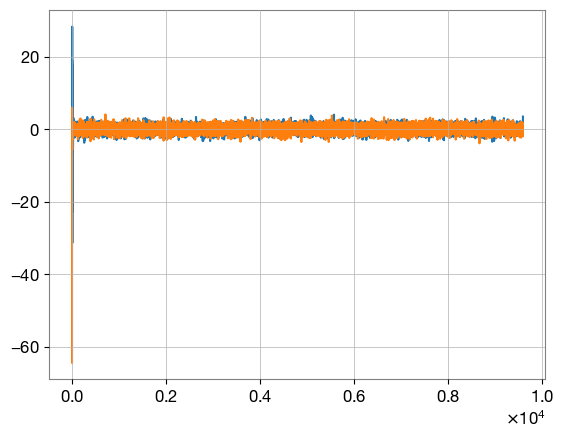

In [43]:
from pycwb.utils import WSeries_to_matrix, transform
import matplotlib.pyplot as plt
import numpy as np
w = transform(tf_map[0], 64, 64)
w.pWavelet.m_Level
# plt.figure(figsize=[6,45], dpi=200.)
plt.plot(WSeries_to_matrix(w)[1])
plt.plot(WSeries_to_matrix(w)[4])
WSeries_to_matrix(w)[4]

In [31]:
# initialize network
from pycwb.modules.coherence import create_network
net, wdm_list = create_network(1, config, data_w_reg)

2023-02-07 11:08:53,511 - pycwb.modules.coherence.network - INFO - Loading MRA
2023-02-07 11:08:53,586 - pycwb.modules.coherence.network - INFO - Filter length = 3.0009765625 (sec)
2023-02-07 11:08:53,635 - pycwb.modules.coherence.network - INFO - Filter length = 1.5009765625 (sec)
2023-02-07 11:08:53,684 - pycwb.modules.coherence.network - INFO - Filter length = 0.7509765625 (sec)
2023-02-07 11:08:53,732 - pycwb.modules.coherence.network - INFO - Filter length = 0.3759765625 (sec)
2023-02-07 11:08:53,782 - pycwb.modules.coherence.network - INFO - Filter length = 0.1884765625 (sec)
2023-02-07 11:08:53,835 - pycwb.modules.coherence.network - INFO - Filter length = 0.0947265625 (sec)
2023-02-07 11:08:53,836 - pycwb.modules.coherence.network - INFO - Initializing network
2023-02-07 11:08:53,836 - pycwb.modules.coherence.network - INFO - Adding ifo L1
2023-02-07 11:08:53,841 - pycwb.modules.coherence.network - INFO - Adding ifo H1
2023-02-07 11:08:53,843 - pycwb.modules.coherence.network -

In [32]:
# calculate coherence
## max energy
from pycwb.modules.coherence import max_energy
alp_list = max_energy(config, net, tf_map, wdm_list)

In [33]:
## threshold
from pycwb.modules.coherence import threshold
threshold_list = threshold(config, net, alp_list)

2023-02-07 11:09:18,966 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=13.6786 Emax=27.3573
2023-02-07 11:09:18,967 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:0-THR:13.67863991787454
2023-02-07 11:09:18,971 - pycwb.modules.coherence.threshold - INFO - live time in zero lag: 584
2023-02-07 11:09:19,498 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=13.6786 Emax=27.3573
2023-02-07 11:09:19,499 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:1-THR:13.67863991787454
2023-02-07 11:09:19,501 - pycwb.modules.coherence.threshold - INFO - live time in zero lag: 584
2023-02-07 11:09:20,020 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=13.6786 Emax=27.3573
2023-02-07 11:09:20,021 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:2-THR:13.67863991787454
2023-02-07 11:09:20,023 - pycwb.modules.coherence.threshold - INFO 

In [34]:
## select pixels
from pycwb.modules.coherence import select_pixels
sparse_table_list = select_pixels(config, net, tf_map, wdm_list, threshold_list)

2023-02-07 11:09:31,367 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 11:09:31,381 - pycwb.modules.coherence.select_pixels - INFO -   0|       92|    382 
2023-02-07 11:09:31,451 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 11:09:31,461 - pycwb.modules.coherence.select_pixels - INFO -   0|       92|    382 
2023-02-07 11:09:31,520 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 11:09:31,530 - pycwb.modules.coherence.select_pixels - INFO -   0|       92|    382 
2023-02-07 11:09:31,596 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 11:09:31,607 - pycwb.modules.coherence.select_pixels - INFO -   0|       92|    382 
2023-02-07 11:09:31,678 - pycwb.modules.coherence.se

In [ ]:
# import cppyy.ll
# cppyy.ll.set_signals_as_exception(True)
#
# with cppyy.ll.signals_as_exception():
#     net.getNetworkPixels(0, threshold_list[0])